In [1]:
import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import time

In [2]:
data = pd.read_csv("cleaned_data.csv") 

In [3]:
data.shape

(755203, 952)

In [4]:
#data = data.sample(n=100000)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755203 entries, 0 to 755202
Columns: 952 entries, mileage to personal_use_only_1.0
dtypes: float64(7), int64(945)
memory usage: 5.4 GB


In [6]:
print("Missing values in dataset:", data.isnull().sum().sum())

Missing values in dataset: 0


In [7]:
# for column in data.columns:
#     print(column)

In [8]:
X = data.drop(columns=['price'])
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h2>XGBoost<h2>

In [9]:
import xgboost as xgb

In [10]:
def hybrid_obj(y_true, y_pred, threshold=0.08):
    err = y_pred - y_true
    grad = np.where(np.abs(err) < threshold, 3 * err**2, 2 * err)
    hess = np.where(np.abs(err) < threshold, 6 * err, 2)
    return grad, hess

In [11]:
#best model after fine tuning
model = xgb.XGBRegressor(n_estimators=370, learning_rate=0.13, max_depth=22, min_child_weight=24,reg_lambda=14.6,subsample=0.92, objective=hybrid_obj)

In [12]:
%%time

model.fit(X_train, y_train)

CPU times: user 13min 16s, sys: 1min 28s, total: 14min 45s
Wall time: 2min 16s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.13, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=22, max_leaves=None,
             min_child_weight=24, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=370, n_jobs=None,
             num_parallel_tree=None,
             objective=<function hybrid_obj at 0x3cda5e200>, ...)

In [13]:
y_pred = model.predict(X_test)

In [14]:
r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)

R-squared score: 0.9323088062172252


In [15]:
model.save_model('xgboost_custom.model')

/Users/omar_bahgat/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:53:31] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [16]:
n_estimators_range = range(10, 700, 10)
r2_scores = []
for n_estimators in n_estimators_range:
    model = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=0.17, max_depth=22, min_child_weight=24,reg_lambda=14.6,subsample=0.94, objective=hybrid_obj, random_state =0)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    print(f"R2: {r2} for n_estimators: {n_estimators}")
    r2_scores.append(r2)

R2: 0.7929399939758569 for n_estimators: 10
R2: 0.9122383850996243 for n_estimators: 20
R2: 0.9203446618801249 for n_estimators: 30
R2: 0.9224227902811801 for n_estimators: 40
R2: 0.9236348752607325 for n_estimators: 50
R2: 0.9246401728005259 for n_estimators: 60
R2: 0.9255284966911692 for n_estimators: 70
R2: 0.9262168715805159 for n_estimators: 80
R2: 0.9270042561629991 for n_estimators: 90
R2: 0.9275887122966433 for n_estimators: 100
R2: 0.9280610221030627 for n_estimators: 110
R2: 0.9287014470612562 for n_estimators: 120
R2: 0.9290293625045613 for n_estimators: 130
R2: 0.9293868959304281 for n_estimators: 140
R2: 0.9297731929721331 for n_estimators: 150
R2: 0.929915431398154 for n_estimators: 160
R2: 0.9300879211883928 for n_estimators: 170
R2: 0.9302626126886139 for n_estimators: 180
R2: 0.9304177817103182 for n_estimators: 190
R2: 0.930582484354229 for n_estimators: 200
R2: 0.9306825894560022 for n_estimators: 210
R2: 0.9307775479668313 for n_estimators: 220
R2: 0.930909310929077

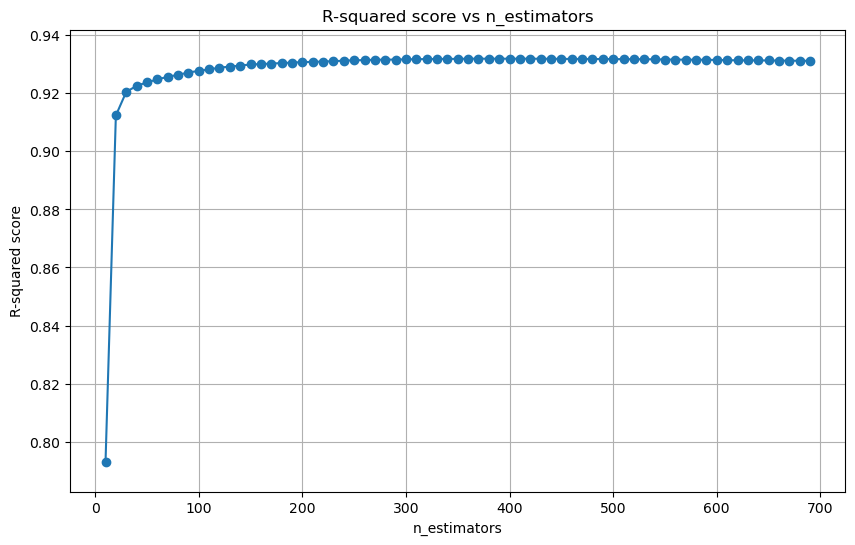

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, r2_scores, marker='o')
plt.title('R-squared score vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('R-squared score')
plt.grid(True)
plt.ylim(min(r2_scores) - 0.01, max(r2_scores) + 0.01)

plt.show()

In [18]:
max_depth_range = range(2, 30, 2)
r2_scores = []
for max_depth in max_depth_range:
    model = xgb.XGBRegressor(n_estimators=370, learning_rate=0.17, max_depth=max_depth, min_child_weight=14,reg_lambda=14.6,subsample=0.94, objective=hybrid_obj,random_state =0)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    print(f"R2: {r2} for max_depth: {max_depth}")
    r2_scores.append(r2)

R2: 0.8210248077464043 for max_depth: 2
R2: 0.8787150617206739 for max_depth: 4
R2: 0.9038582212075364 for max_depth: 6
R2: 0.915902805451519 for max_depth: 8
R2: 0.9237436316195938 for max_depth: 10
R2: 0.9282020863784208 for max_depth: 12
R2: 0.9302773456252259 for max_depth: 14
R2: 0.9312875446418665 for max_depth: 16
R2: 0.9322361086975214 for max_depth: 18
R2: 0.9316270787745005 for max_depth: 20
R2: 0.931766167052659 for max_depth: 22
R2: 0.9317228785851978 for max_depth: 24
R2: 0.9312817320738296 for max_depth: 26
R2: 0.9304025306600785 for max_depth: 28


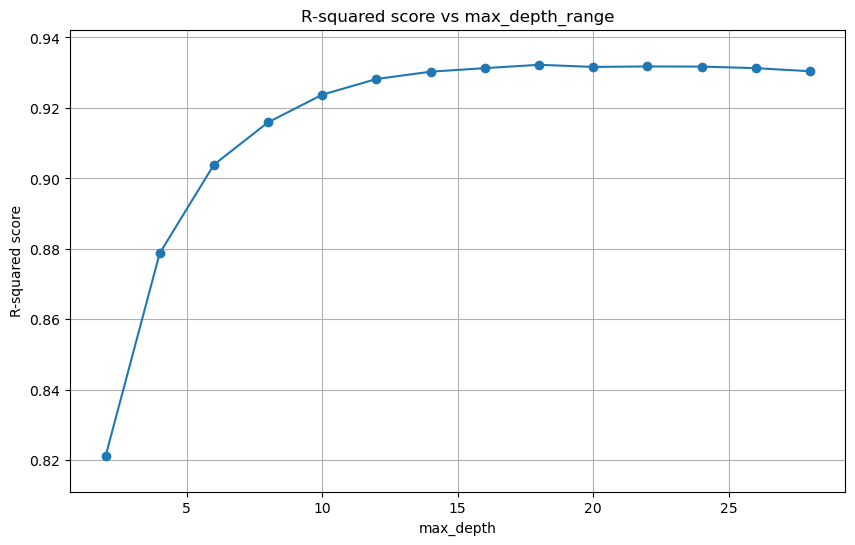

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, r2_scores, marker='o')
plt.title('R-squared score vs max_depth_range')
plt.xlabel('max_depth')
plt.ylabel('R-squared score')
plt.grid(True)
plt.ylim(min(r2_scores) - 0.01, max(r2_scores) + 0.01)

plt.show()

In [20]:
# Loop for min_child_weight
min_child_weight_values =  range(1, 30, 1)
r2_scores = []
for min_child_weight in min_child_weight_values:
    model = xgb.XGBRegressor(n_estimators=370, learning_rate=0.2, max_depth=14, min_child_weight=min_child_weight,reg_lambda=14.6,subsample=0.94, objective=hybrid_obj,random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"R2: {r2} for min_child_weight: {min_child_weight}")
    r2_scores.append(r2)

R2: 0.9299458585424927 for min_child_weight: 1
R2: 0.9301860650392253 for min_child_weight: 2
R2: 0.9304688200226793 for min_child_weight: 3
R2: 0.9306114534099483 for min_child_weight: 4
R2: 0.9303400486020477 for min_child_weight: 5
R2: 0.9302760769732834 for min_child_weight: 6
R2: 0.930806074819481 for min_child_weight: 7
R2: 0.9309215620448977 for min_child_weight: 8
R2: 0.9305181360768713 for min_child_weight: 9
R2: 0.9307799076928538 for min_child_weight: 10
R2: 0.9302891994216907 for min_child_weight: 11
R2: 0.9305300278427936 for min_child_weight: 12
R2: 0.9309177162519138 for min_child_weight: 13
R2: 0.9309435457435618 for min_child_weight: 14
R2: 0.930245897619517 for min_child_weight: 15
R2: 0.9303990714310955 for min_child_weight: 16
R2: 0.9307483314104229 for min_child_weight: 17
R2: 0.9307997935343779 for min_child_weight: 18
R2: 0.9305885646342669 for min_child_weight: 19
R2: 0.930421567569268 for min_child_weight: 20
R2: 0.9305582925203739 for min_child_weight: 21
R2: 

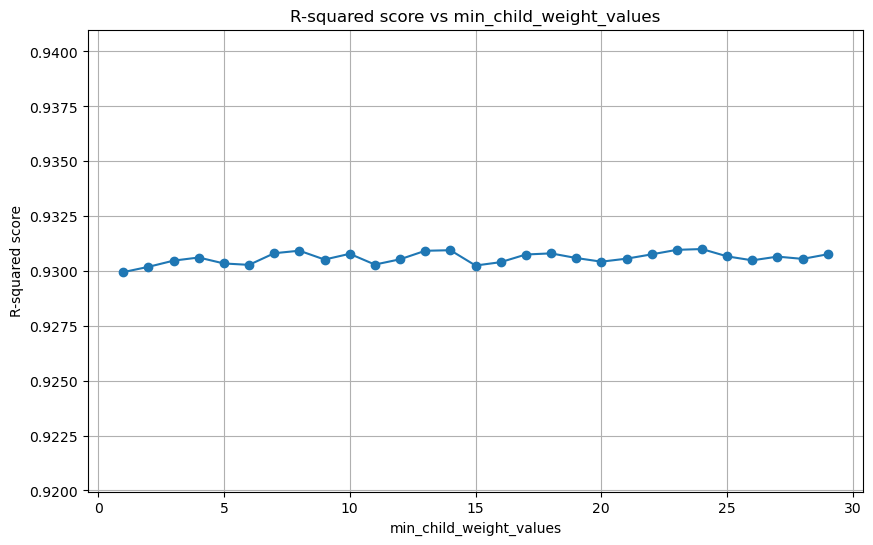

In [21]:
# Plot for min_child_weight
plt.figure(figsize=(10, 6))
plt.plot(min_child_weight_values, r2_scores, marker='o')
plt.title('R-squared score vs min_child_weight_values')
plt.xlabel('min_child_weight_values')
plt.ylabel('R-squared score')
plt.grid(True)
plt.ylim(min(r2_scores) - 0.01, max(r2_scores) + 0.01)

plt.show()


In [22]:
# Loop for reg_lambda
reg_lambda_values = np.arange(0, 30, 0.5)
r2_scores = []
for reg_lambda in reg_lambda_values:
    model = xgb.XGBRegressor(n_estimators=370, learning_rate=0.17, max_depth=22, min_child_weight=14,reg_lambda=reg_lambda,subsample=0.94, objective=hybrid_obj,random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"R2: {r2} for reg_lambda: {reg_lambda}")
    r2_scores.append(r2)


R2: 0.9282507062792656 for reg_lambda: 0.0
R2: 0.9291659920711002 for reg_lambda: 0.5
R2: 0.929886438865258 for reg_lambda: 1.0
R2: 0.9299885818393803 for reg_lambda: 1.5
R2: 0.9301646603919326 for reg_lambda: 2.0
R2: 0.930205725799084 for reg_lambda: 2.5
R2: 0.9307477779766057 for reg_lambda: 3.0
R2: 0.9308259693903761 for reg_lambda: 3.5
R2: 0.9309160881283144 for reg_lambda: 4.0
R2: 0.9304179673284917 for reg_lambda: 4.5
R2: 0.9311177160148143 for reg_lambda: 5.0
R2: 0.9311774955007724 for reg_lambda: 5.5
R2: 0.9313327767960295 for reg_lambda: 6.0
R2: 0.9315519482866674 for reg_lambda: 6.5
R2: 0.9313940052585645 for reg_lambda: 7.0
R2: 0.9314964260744508 for reg_lambda: 7.5
R2: 0.9315712446579741 for reg_lambda: 8.0
R2: 0.9313974384780757 for reg_lambda: 8.5
R2: 0.9314102300983984 for reg_lambda: 9.0
R2: 0.9314369320866711 for reg_lambda: 9.5
R2: 0.9314165099295089 for reg_lambda: 10.0
R2: 0.9318267001000475 for reg_lambda: 10.5
R2: 0.9317052546981086 for reg_lambda: 11.0
R2: 0.9318

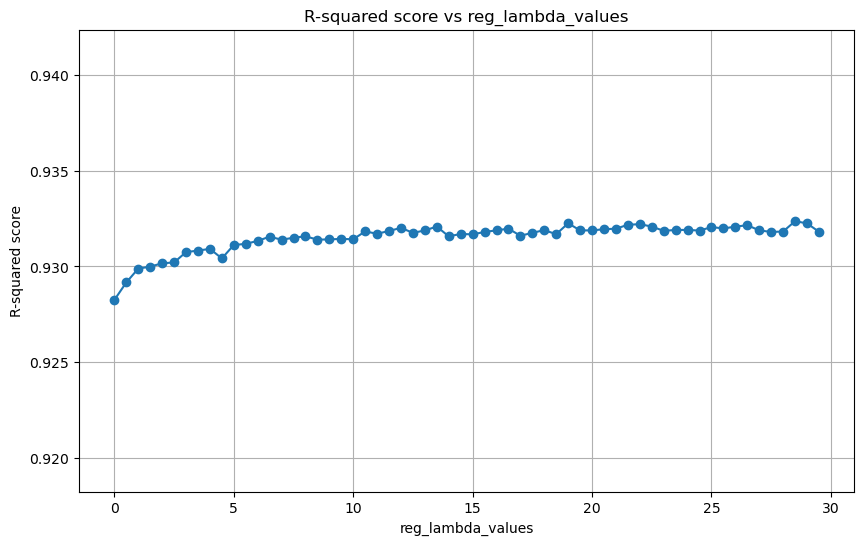

In [23]:
# Plot for reg_lambda
plt.figure(figsize=(10, 6))
plt.plot(reg_lambda_values, r2_scores, marker='o')
plt.title('R-squared score vs reg_lambda_values')
plt.xlabel('reg_lambda_values')
plt.ylabel('R-squared score')
plt.grid(True)
plt.ylim(min(r2_scores) - 0.01, max(r2_scores) + 0.01)

plt.show()

In [24]:
# Loop for subsample
subsample_values = np.arange(0.1, 1, 0.02)
r2_scores = []
for subsample in subsample_values:
    model = xgb.XGBRegressor(n_estimators=370, learning_rate=0.17, max_depth=22, min_child_weight=14,reg_lambda=14.6,subsample=subsample, objective=hybrid_obj, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"R2: {r2} for subsample: {subsample}")
    r2_scores.append(r2)

R2: 0.9164675177624353 for subsample: 0.1
R2: 0.9189163448533497 for subsample: 0.12000000000000001
R2: 0.9199188271175117 for subsample: 0.14
R2: 0.9222324669032453 for subsample: 0.16000000000000003
R2: 0.9233454418874703 for subsample: 0.18000000000000002
R2: 0.9235056283249955 for subsample: 0.2
R2: 0.9244484270043956 for subsample: 0.22000000000000003
R2: 0.9252525870317634 for subsample: 0.24000000000000002
R2: 0.9257231389830209 for subsample: 0.26
R2: 0.9262000590860967 for subsample: 0.28
R2: 0.9267269397149862 for subsample: 0.30000000000000004
R2: 0.9272096101951754 for subsample: 0.32000000000000006
R2: 0.9278743517840224 for subsample: 0.3400000000000001
R2: 0.9279898678327152 for subsample: 0.3600000000000001
R2: 0.928396136567988 for subsample: 0.38
R2: 0.9286008965941523 for subsample: 0.4
R2: 0.9287903421790571 for subsample: 0.42000000000000004
R2: 0.9287331029208328 for subsample: 0.44000000000000006
R2: 0.928759195275401 for subsample: 0.4600000000000001
R2: 0.92915

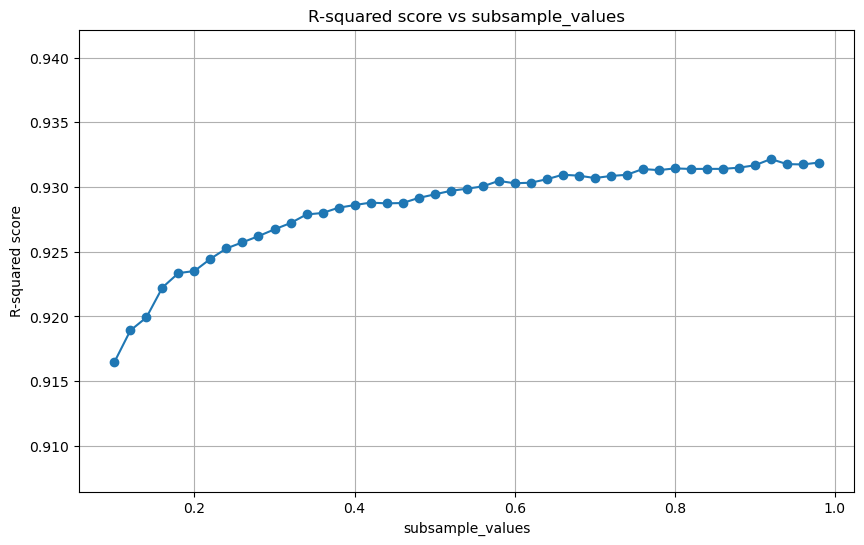

In [25]:
# Plot for sub_sample
plt.figure(figsize=(10, 6))
plt.plot(subsample_values, r2_scores, marker='o')
plt.title('R-squared score vs subsample_values')
plt.xlabel('subsample_values')
plt.ylabel('R-squared score')
plt.grid(True)
plt.ylim(min(r2_scores) - 0.01, max(r2_scores) + 0.01)

plt.show()

In [66]:
# Loop for learning_rate
learning_rate_values = np.arange(0.01, 0.3, 0.01)
r2_scores = []
for learning_rate in learning_rate_values:
    model = xgb.XGBRegressor(n_estimators=370, learning_rate=learning_rate,max_depth=22, min_child_weight=24,reg_lambda=14.6,subsample=0.92, objective=hybrid_obj,random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"R2: {r2} for learning_rate: {learning_rate}")
    r2_scores.append(r2)

R2: 0.9145475104270111 for learning_rate: 0.01
R2: 0.9246750939353936 for learning_rate: 0.02
R2: 0.9271964360545383 for learning_rate: 0.03
R2: 0.9287466441830635 for learning_rate: 0.04
R2: 0.9296649601856225 for learning_rate: 0.05
R2: 0.930838774303957 for learning_rate: 0.060000000000000005
R2: 0.9312581314659766 for learning_rate: 0.06999999999999999
R2: 0.9318111204452315 for learning_rate: 0.08
R2: 0.9319557160434857 for learning_rate: 0.09
R2: 0.9322130498008299 for learning_rate: 0.09999999999999999
R2: 0.9324357446356301 for learning_rate: 0.11
R2: 0.9324869955340949 for learning_rate: 0.12
R2: 0.932518493143312 for learning_rate: 0.13
R2: 0.9321662660958506 for learning_rate: 0.14
R2: 0.9318495594422919 for learning_rate: 0.15000000000000002
R2: 0.9319363224958761 for learning_rate: 0.16
R2: 0.9316649214214051 for learning_rate: 0.17
R2: 0.9320423166974947 for learning_rate: 0.18000000000000002
R2: 0.9313243098369927 for learning_rate: 0.19
R2: 0.9311286278831238 for learni

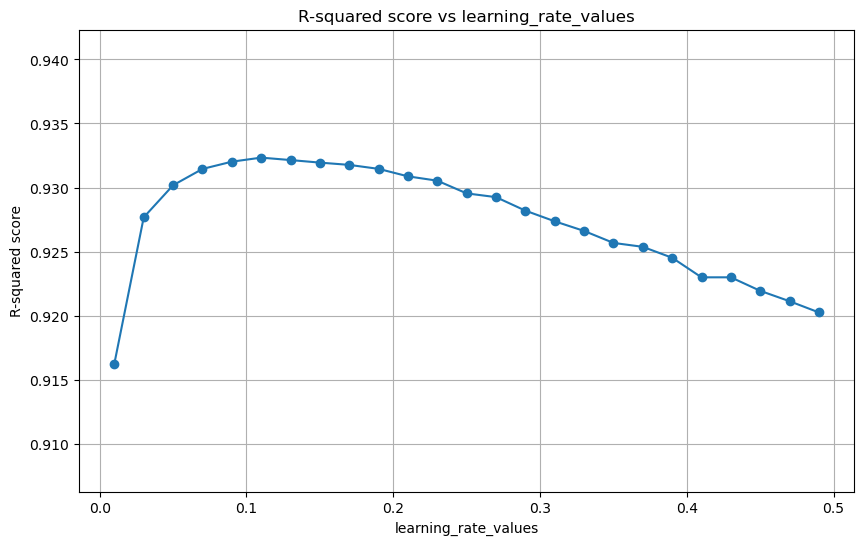

In [ ]:
# Plot for learning_rate
plt.figure(figsize=(10, 6))
plt.plot(learning_rate_values, r2_scores, marker='o')
plt.title('R-squared score vs learning_rate_values')
plt.xlabel('learning_rate_values')
plt.ylabel('R-squared score')
plt.grid(True)
plt.ylim(min(r2_scores) - 0.01, max(r2_scores) + 0.01)

plt.show()